In [25]:
from betting_kings.utils.db.read_query_as_df import read_query_as_df
from dateutil.relativedelta import relativedelta
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [26]:
df_now = read_query_as_df("SELECT * FROM pinnacle_bet_archive where sport_id=2 and " + 
                          "match_date >= cast(NOW() - INTERVAL 30 DAY as DATE);")
df_old = read_query_as_df("SELECT * FROM pinnacle_bet_archive where sport_id=2 and " + 
                          "match_date > cast(NOW() - INTERVAL 15 DAY as DATE) and " + 
                          "match_date <= cast(NOW() - INTERVAL 6 DAY as DATE);")
df_old.match_date = [i + relativedelta(days=7) for i in df_old.match_date]

In [27]:
def compute_margin(x):
    if x['bet_status'] == 'WON':
        return x['bet_win']
    elif x['bet_status'] == 'LOSE':
        return - x['bet_amount']
    else:
        return 0

In [28]:
df_now['match_date'] = df_now['match_date'].apply(lambda x: x.date())
df_old['match_date'] = df_old['match_date'].apply(lambda x: x.date())

In [29]:
df_now['margin']  = df_now.T.apply(lambda x: compute_margin(x))
df_old['margin']  = df_old.T.apply(lambda x: compute_margin(x))

In [30]:
df_now['accuracy']  = df_now.T.apply(lambda x: int(x['bet_status'] == 'WON'))
df_old['accuracy']  = df_old.T.apply(lambda x: int(x['bet_status'] == 'WON'))

In [31]:
cumulate_margin = pd.concat([df_now.groupby(by='match_date').sum().cumsum().margin.rename('current'), 
                             df_old.groupby(by='match_date').sum().cumsum().margin.rename('week_to_date')], axis=1, sort=True)

daily_margin = pd.concat([df_now.groupby(by='match_date').sum().margin.rename('current'), 
                          df_old.groupby(by='match_date').sum().margin.rename('week_to_date')], axis=1, sort=True)

bet_amount = pd.concat([df_now.groupby(by='match_date').bet_amount.sum().rename('current'),
                        df_old.groupby(by='match_date').bet_amount.sum().rename('week_to_date')], axis=1, sort=True)

events_number = pd.concat([df_now.groupby(by='match_date').bet_amount.count().rename('current'),
                           df_old.groupby(by='match_date').bet_amount.count().rename('week_to_date')], axis=1, sort=True)

accuracy = pd.concat([df_now.groupby(by='match_date').sum().accuracy.rename('current'),
                      df_old.groupby(by='match_date').sum().accuracy.rename('week_to_date'),], axis=1, sort=True)
accuracy = accuracy.divide(events_number)

perc_margin = daily_margin.divide(bet_amount)

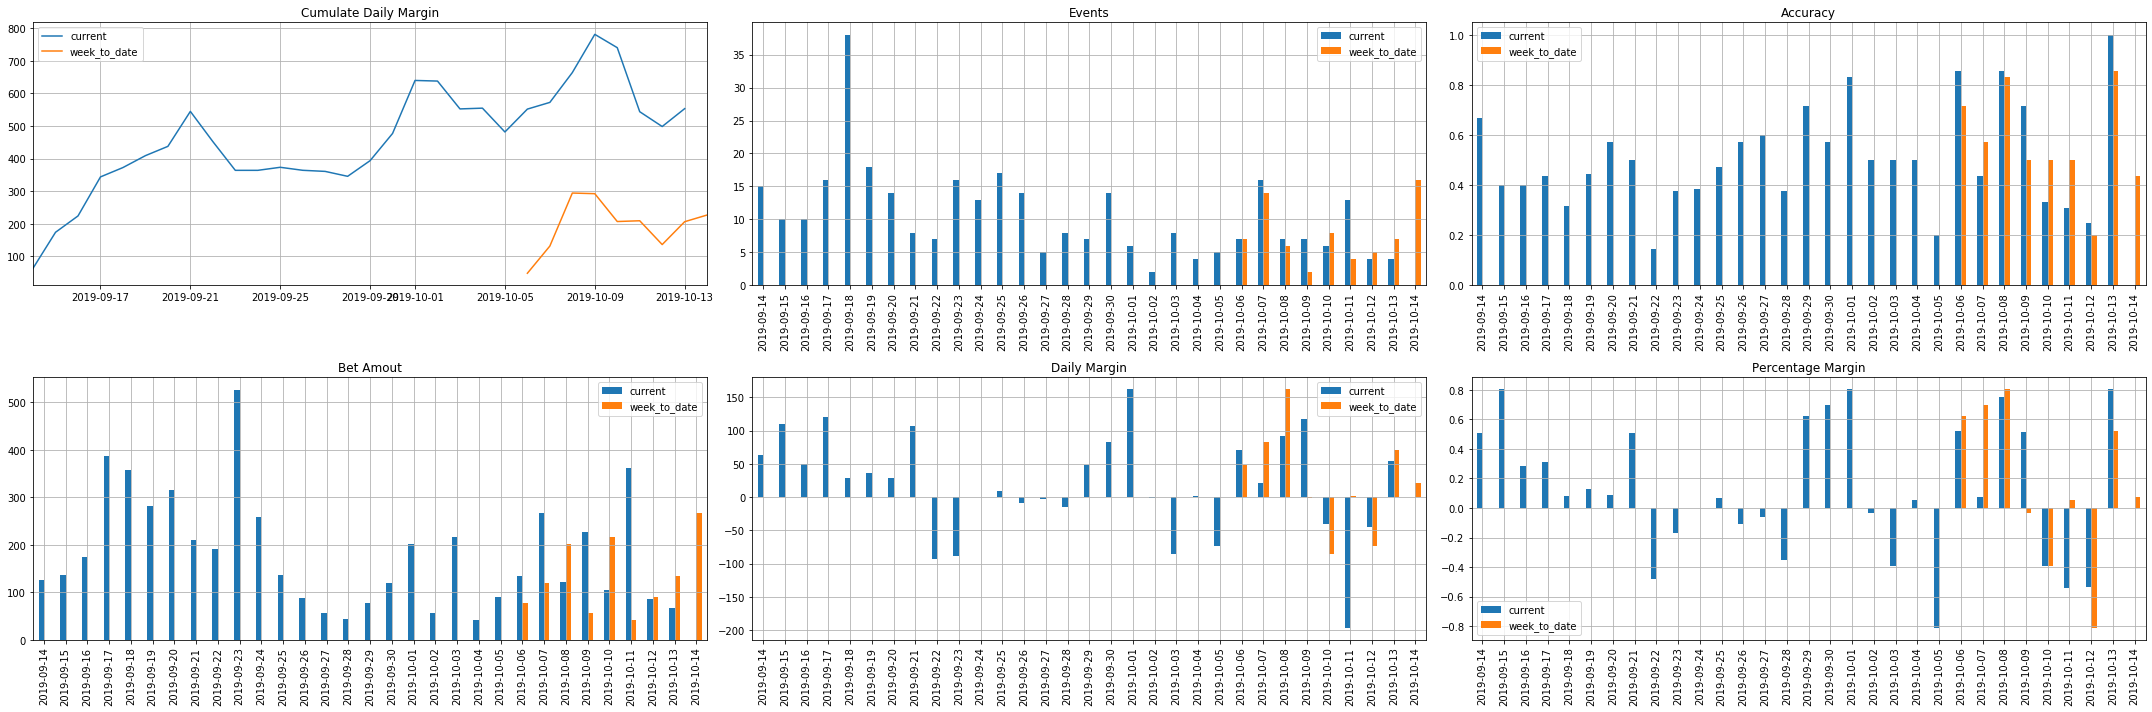

In [32]:
fig, ax = plt.subplots(2, 3, figsize=(30, 10))

cumulate_margin.plot(ax=ax[0,0], grid=True, title='Cumulate Daily Margin')
events_number.plot(ax=ax[0,1], grid=True, title='Events', kind='bar')
accuracy.plot(ax=ax[0,2], grid=True, title='Accuracy', kind='bar')

bet_amount.plot(ax=ax[1,0], grid=True, title='Bet Amout', kind='bar')
daily_margin.plot(ax=ax[1,1], grid=True, title='Daily Margin', kind='bar')
perc_margin.plot(ax=ax[1,2], grid=True, title='Percentage Margin', kind='bar')

plt.tight_layout()